# softmax回归模型是logistic回归模型在多分类问题上的推广，在多分类问题中，类标签y可以取两个以上的值。本文基于MNIST手写数字数据集来演示如何使用Pytorch实现softmax回归。🎄

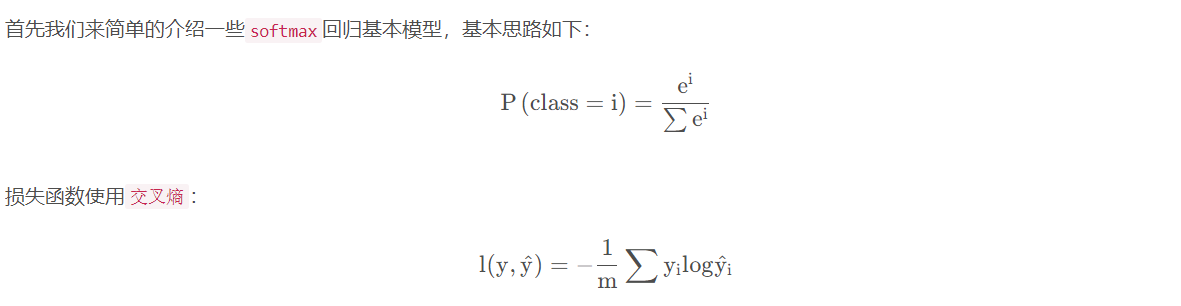

# 1. 数据集导入

In [1]:
# 当如相关库
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
'''
在这里与之前不同的是我们导入了torchvision，它是处理计算机视觉常用的一个库。
沐神在这里使用了FashionMnist数据集，我在这里还是使用Mnist数据集，具体的下载代码如下所示。
其中train参数可以设置训练集和测试集
'''

D:\ANnaconda\envs\HBHB\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'\n在这里与之前不同的是我们导入了torchvision，它是处理计算机视觉常用的一个库。\n沐神在这里使用了FashionMnist数据集，我在这里还是使用Mnist数据集，具体的下载代码如下所示。\n其中train参数可以设置训练集和测试集\n'

In [2]:
trans = transforms.ToTensor()
train = datasets.MNIST(root='./data',download=True,train=True,transform=trans)
test = datasets.MNIST(root='./data',download=True,train=False,transform=trans)


Mnist数据集由10个数字的图像组成的。其中训练集有60000张图片，测试集有10000张图片。训练集用于模型的拟合，测试集用于评估模型的好坏

In [3]:
len(train), len(test)

(60000, 10000)

每张图片的像素均是28*28,并且是灰度图像，所以通道数为1

In [4]:
train[0][0].shape


torch.Size([1, 28, 28])

我们来看一下训练集中的特征和标签，.

In [5]:
X, y = next(iter(data.DataLoader(train, batch_size=25)))
y

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1])

In [6]:
#y代表的是0-9的数字，下面我们将图形绘制出来
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): 
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

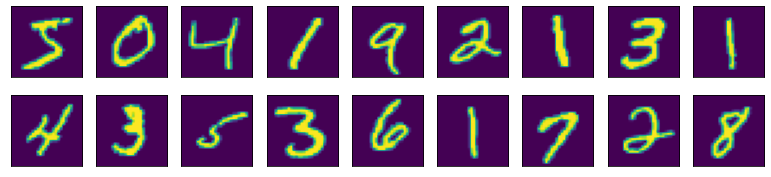

In [7]:
X, y = next(iter(data.DataLoader(train, batch_size=25)))
show_images(X.reshape(25, 28, 28), 2, 9)

可以看到第一张图片是5，第二张图片是0。接下来我们想要做的事情是，给电脑一张图片，如何让其返回一个正确的数字。

# 2.初始化参数

In [8]:
# 因为softmax回归需要输入的数据是一个向量，因此首先我们需要将数据进行转换,下面要注意初始化参数的大小。
num_inputs = 784
num_outputs = 10
# 初始化为正态分布
W = torch.normal(0,0.01,size = (num_inputs,num_outputs),requires_grad = True)
b = torch.zeros(num_outputs,requires_grad=True)


# 3.定义softmax回归

根据softmax回归定义，我们可以通过以下三步实现：

1.对每一项求指数
2.求和
3.用每一行的数除以和

In [9]:
def softmax(X):
    X_exp = torch.exp(X)
    s = X_exp.sum(1, keepdims=True)
    return X_exp / s


In [10]:
#下面我们举一个简单的例子看一下softmax函数是如何工作的
z = torch.rand(3, 5)
h = softmax(z)
h


tensor([[0.1940, 0.1366, 0.3063, 0.1876, 0.1754],
        [0.1146, 0.2717, 0.2262, 0.1150, 0.2726],
        [0.1583, 0.2502, 0.2041, 0.2059, 0.1815]])

这样就得出了每一个样本中每一类的概率

In [11]:
#进一步定义softmax回归模型
def net(X):
    return softmax((X.reshape((-1,W.shape[0])).matmul(W)+b))


# 4. 损失函数定义

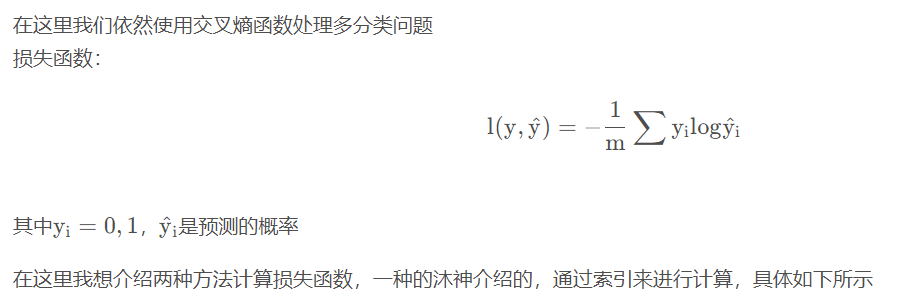

In [12]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])# 这里使用y来进行索引
#这里我们使用了y来进行索引，我们来看看一个具体的例子

In [13]:
y_true = torch.tensor([0,1])
y_hat = torch.tensor([[0.1,0.2,0.7],[0.3,0.5,0.2]])
y_hat[[0,1],y_true]


tensor([0.1000, 0.5000])

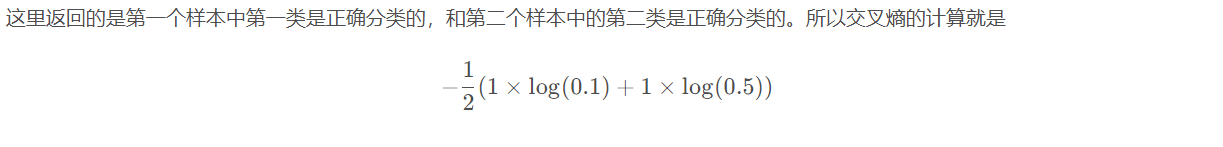

In [14]:
cross_entropy(y_hat,y_true).mean()
#等价于

tensor(1.4979)

In [15]:
(-np.log(0.1)-np.log(0.5))/2


1.4978661367769954

上面这种方式虽然简洁，但是可能不太好理解，下面介绍一种更直观的方式。首先我们要将y转换成one-hot编码。

In [16]:
y_true = torch.tensor([0,1])
y_hat = torch.tensor([[0.1,0.2,0.7],[0.3,0.5,0.2]])
y_one_hot = torch.zeros_like(y_hat)
y_one_hot.scatter_(1, y_true.unsqueeze(1), 1)
y_one_hot


tensor([[1., 0., 0.],
        [0., 1., 0.]])

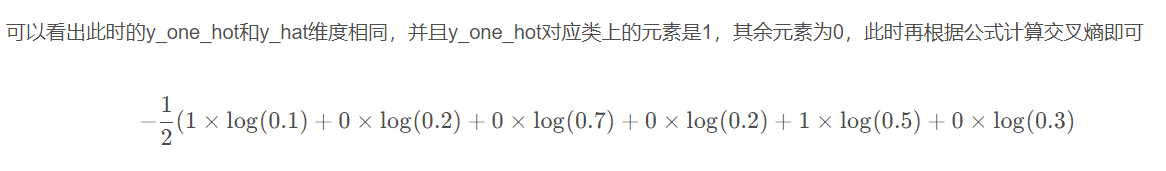

In [17]:
cost = (y_one_hot * -torch.log(y_hat)).sum(dim=1).mean()
cost


tensor(1.4979)

In [18]:
#可以看出两种方法得到的结果一致
def opt(W,b):
    return optim.SGD([W,b],lr=0.1)


# 5.模型训练

In [19]:
'''
初始化参数
'''
W = torch.zeros((784, 10), requires_grad=True)
b = torch.zeros(10, requires_grad=True)
'''
定义SGD优化器
'''
optimizer = optim.SGD([W, b], lr=0.1)

'''
训练模型
'''
nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    z = net(X)  #计算softmax回归结果 
    cost = cross_entropy(z,y)#计算损失函数
    # SGD求解参数
    optimizer.zero_grad()#初始化参数
    cost.mean().backward()#后向传播求参数
    optimizer.step()#更新参数
    if epoch % 100 == 0 :
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.mean().item()
        ))
        


Epoch    0/1000 Cost: 2.302585
Epoch  100/1000 Cost: 0.062107
Epoch  200/1000 Cost: 0.028699
Epoch  300/1000 Cost: 0.018586
Epoch  400/1000 Cost: 0.013733
Epoch  500/1000 Cost: 0.010887
Epoch  600/1000 Cost: 0.009018
Epoch  700/1000 Cost: 0.007697
Epoch  800/1000 Cost: 0.006713
Epoch  900/1000 Cost: 0.005953
Epoch 1000/1000 Cost: 0.005348


# 6.模型预测

tensor([7, 3, 1, 0, 4, 1, 4, 1, 4, 7])

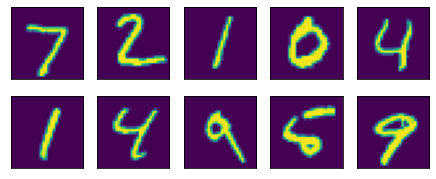

In [20]:
X_test, y_test = next(iter(data.DataLoader(test, batch_size=10)))
show_images(X_test.reshape(10, 28, 28), 2, 5)

z = net(X_test)
predict = z.argmax(dim=1)
predict
#可以看出模型效果一般。因为我们刚刚只使用了训练集中的25个样本，所以在训练集上预测效果并不好。
#如何提升预测精度问题将在后续讨论。

# 7.使用内置api简单实现softmax回归

In [20]:
from torch import nn

# 一样导入数据集
X, y = next(iter(data.DataLoader(train, batch_size=25)))
# 定义模型
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))#nn.Flatten()的作用是将输入的特征转换为一个向量
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)#初始化参数
net.apply(init_weights)
#计算损失函数
loss = nn.CrossEntropyLoss(reduction='none')
# 定义SGD优化器
trainer = torch.optim.SGD(net.parameters(), lr=0.1)
nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    z = net(X)#计算模型结果
    cost = loss(z,y)#计算损失函数
    # SGD求解参数
    trainer.zero_grad()#初始化参数
    cost.mean().backward()#后向传播求参数
    trainer.step()#更新参数
    if epoch % 100 == 0 :
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.mean().item()
        ))


Epoch    0/1000 Cost: 2.315349
Epoch  100/1000 Cost: 0.062056
Epoch  200/1000 Cost: 0.028685
Epoch  300/1000 Cost: 0.018579
Epoch  400/1000 Cost: 0.013728
Epoch  500/1000 Cost: 0.010884
Epoch  600/1000 Cost: 0.009016
Epoch  700/1000 Cost: 0.007695
Epoch  800/1000 Cost: 0.006712
Epoch  900/1000 Cost: 0.005952
Epoch 1000/1000 Cost: 0.005346
